# 코로나바이러스의 확진을 막기위해서 어떻게 해야 했을까?

### 우리가 알고 있었던 것들이 정말 맞는 것일까? 데이터를 통해서 확인해 보자
우리가 이 데이터를 사용해서 얻고자 하는 인사이트는  
코로나 바이러스의 확진을 막기위해서 우리는 어떤 행동을 했어야 하는가에 대한 것이다,  
다들 뉴스 및 여러 채널을 통해서 들은 것이 있었을 것이다.  
이번 EDA를 통해서 과연 그러한 내용들이 맞는 것일지 우리가 몰랐던 다른 무엇인가를 발견할 수 있을지 한번 확인해 보고자 한다.

### 데이터를 들여다보자

우리가 사용하는 데이터는 과거의 데이터이다.  
제공된 전체 11개의 파일을 조사한결과 다음과 같은 기간동안 조사되었다.  
특이 사항이 없다면 우리는 2020년 1월 20일 ~ 2020년6월 30일 까지의 데이터를 사용하게 될 것이다.

- PatientInfo.csv 2020-01-20 ~ 2020-06-30
- Policy.csv 2020-01-03 ~ 2020-06-10
- SearchTrend.csv 2016-01-01 ~ 2020-06-29
- SeoulFloating 2020-01-01 ~ 2020-05-31
- Time.csv 2020-01-20 ~ 2020-06-30
- TimeAge.csv 2020-03-02 ~ 2020-06-30
- TimeGender.csv 2020-03-02 ~ 2020-06-30
- TimeProvince.csv 2020-01-20 ~ 2020-06-30
- Weather.csv 2020-01-20 ~ 2020-06-30

In [209]:
# module import

import pandas as pd 
import datetime as datetime 
from datetime  import timedelta
from dateutil.relativedelta import relativedelta
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go
import folium as g
import warnings

from plotnine import *
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
plt.style.use('seaborn')
sns.set()

print('Setup completed ^_____^')

Setup completed ^_____^


## 0. 전체 데이터 로딩

In [20]:
# 모든 데이터를 로드한다.

C_df = pd.read_csv("./data/covid19/Case.csv")
PI_df = pd.read_csv("./data/covid19/PatientInfo.csv")
Pol_df = pd.read_csv("./data/covid19/Policy.csv")
R_df = pd.read_csv("./data/covid19/Region.csv")
ST_df = pd.read_csv("./data/covid19/SearchTrend.csv")
SF_df = pd.read_csv("./data/covid19/SeoulFloating.csv")
T_df = pd.read_csv("./data/covid19/Time.csv")
TA_df = pd.read_csv("./data/covid19/TimeAge.csv")
TG_df = pd.read_csv("./data/covid19/TimeGender.csv")
TP_df = pd.read_csv("./data/covid19/TimeProvince.csv")
W_df = pd.read_csv("./data/covid19/Weather.csv")

print('Data Load completed ^_____^')

Data Load completed ^_____^


## 확진자 한명이 얼마나 많은 다른 사람들을 감염 시켰는가?

In [21]:
#  Patient Info 데이터 확인

display(PI_df.head())

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


patient_id 열에서 중복된 id를 검출했다.  
데이터 특성상 확진자 한명당 동일한 아이디를 가질 수 었고   
동일한 인물로 확인되었기 때문에 오류로 판단하고 행 한개 전체를 지웠다.

In [22]:
# patient_id 열에서 중복된 id를 검출했다.
# 특성상 확진자 한명당 동일한 아이디를 가질 수 었고 
# 동일한 인물로 확인되었기 때문에 오류로 판단하고 행 한개 전체를 지웠다.

PI_df['patient_id'].value_counts()

1200012238    2
1000000001    1
3009000020    1
3009000018    1
3009000017    1
             ..
1400000079    1
1400000078    1
1400000077    1
1400000076    1
7000000019    1
Name: patient_id, Length: 5164, dtype: int64

환자 아이디별로 얼마나 많은 사람들 감겸 시켰는지 확인해 보도록 하자  
타인에게 감염을 많이 시켰다는 의미는, 접촉이 많았다는 것으로 해석 할 수 있다.  
행동적인 관점에서 보면 다음과 같이 해석할 있다.

(1) 움직임이 많은 사람  
(2) 사회적 활동이 많은 사람

또는 의학적인 관점에서 보면 강한 전염력을 보유한 사람으로 해석 할 수 있다.

전염을 많이 시킨 사람의 인구통계학 적인 부분을 조사 해 보도록 하겠다.

In [484]:
infected_by = PI_df['infected_by'].value_counts()
print(infected_by)

2000000205    51
4100000008    27
2000000167    24
1400000209    24
2000000309    21
              ..
2000000050     1
2000000016     1
1000000014     1
2000000007     1
7000000009     1
Name: infected_by, Length: 606, dtype: int64


In [485]:
print('감염을 시킨 사람수 max: ', infected_by.max())
print('감염을 시킨 사람수 min: ', infected_by.min())

감염을 시킨 사람수 max:  51
감염을 시킨 사람수 min:  1


In [ ]:
위 결과를 보면
2000000205 확진자가 무려 51명을 감염을 시킨 것으로 확인된다.

5명 이하를 감염시킨 사람이 몇 퍼센트에 해당하는지 확인해보자.

In [477]:
# 여기서 1명 감염 시킨 사람은 별 의미가 없으므로 제거 하도록 한다. 라고 하려고 했는데 
# 5명 이하를 감염시킨 의미가 없지 않

idx = infected_by[infected_by==1].index
idx
infected_by.drop(idx, inplace=True)

In [478]:
x = infected_by.index
y = infected_by.values

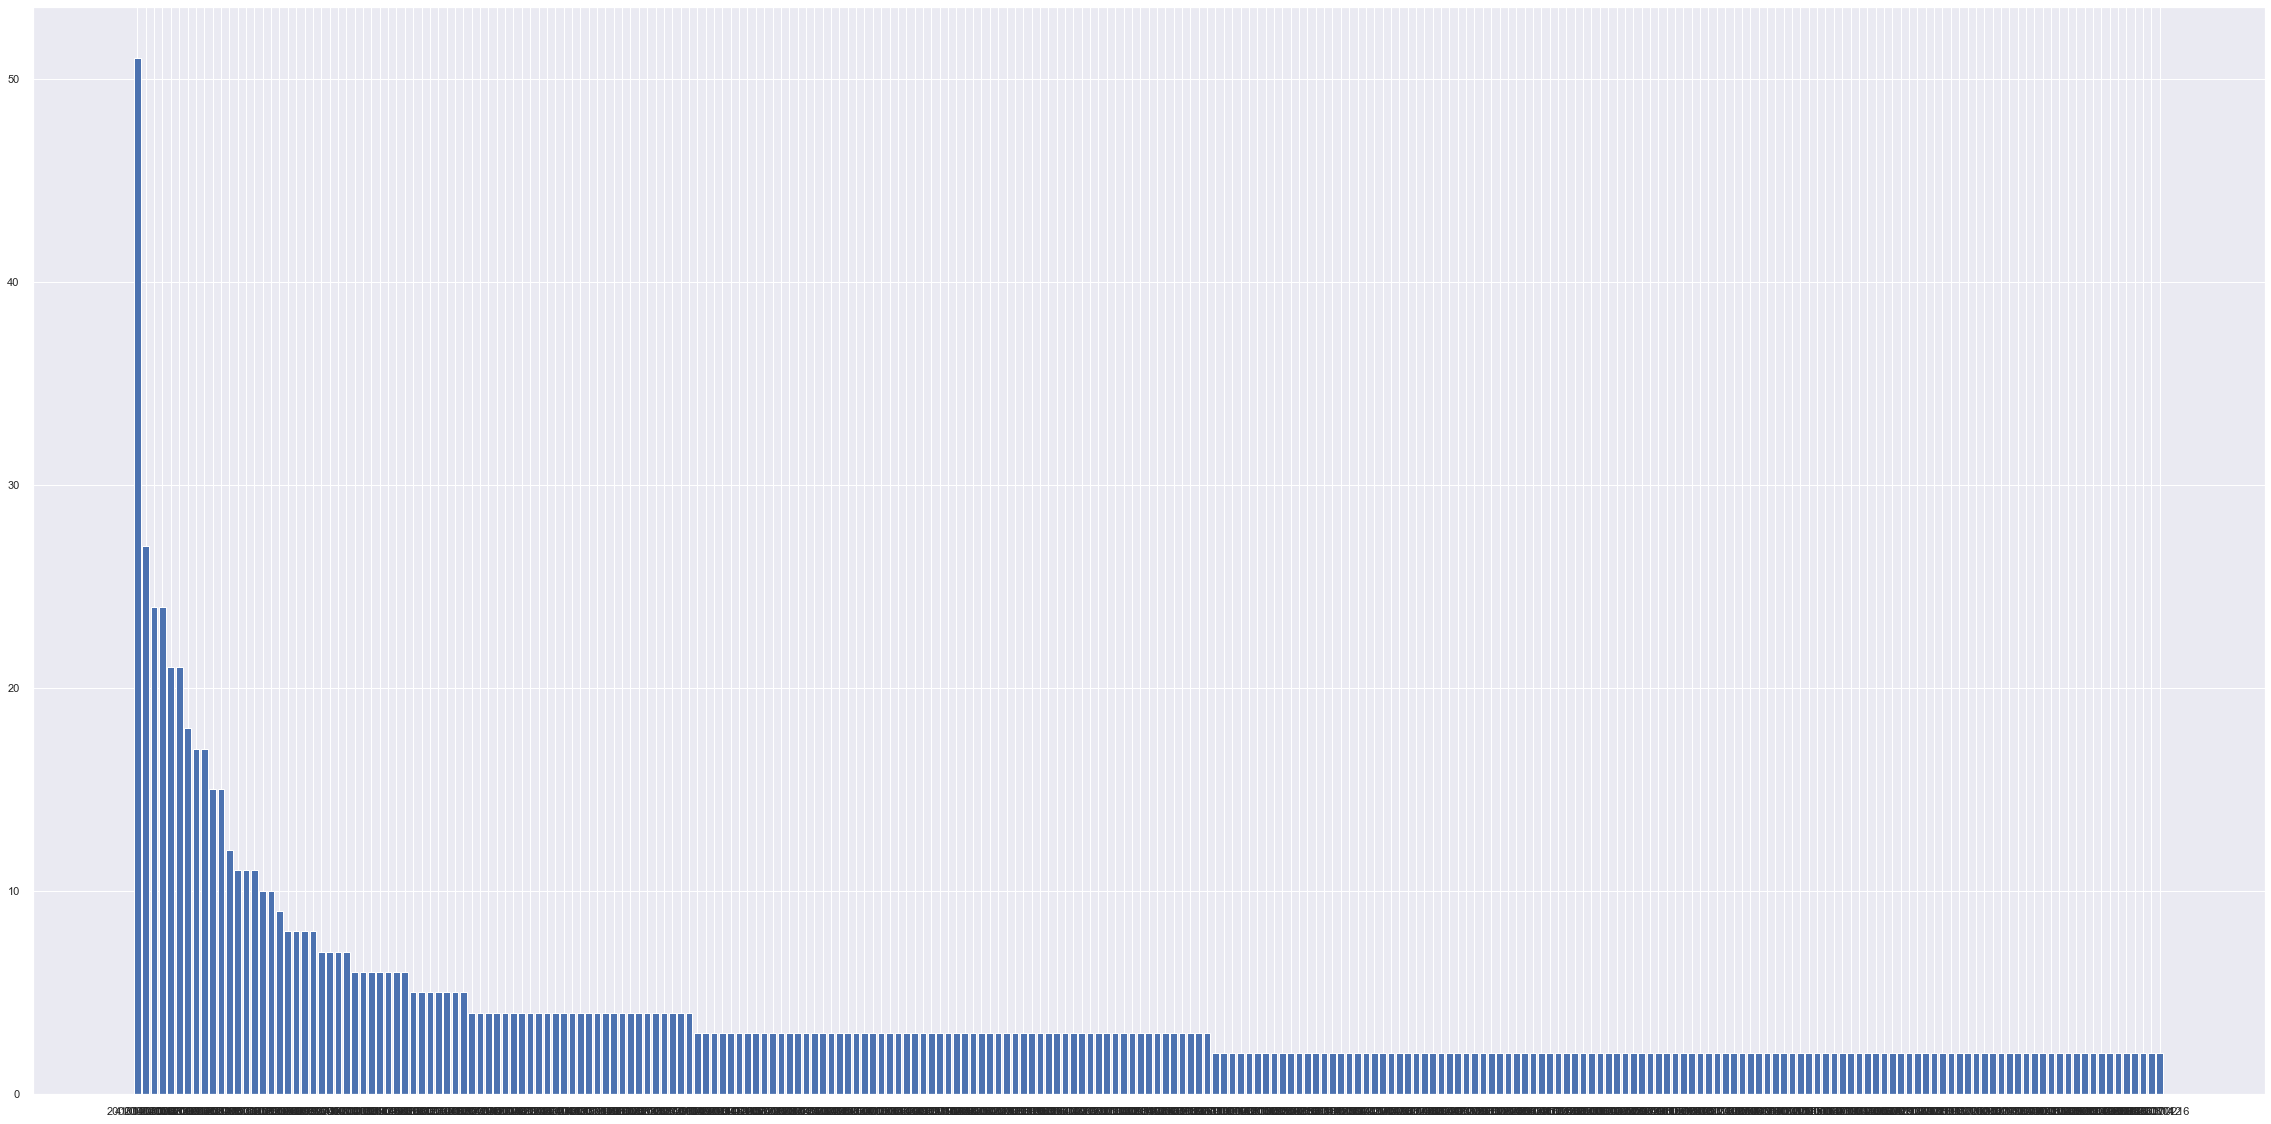

In [486]:
plt.figure(figsize=(40,20)) 
plt.bar(x, y)
plt.show()

In [375]:
infected_by.keys()

Index(['2000000205', '4100000008', '2000000167', '1400000209', '2000000309',
       '4100000006', '1000000125', '1200000031', '2000000508', '2000000476',
       ...
       '2000000093', '2000000080', '2000000062', '2000000081', '2000000049',
       '2000000050', '2000000016', '1000000014', '2000000007', '7000000009'],
      dtype='object', length=606)

### (1) 감염경로(infection case)에 대한 분석
저당시에는 확진자가 많이 않았기 때문에 충분한 역학조사가 이루어져서 어디서 감염이 되었는지를 확인할 수 있었다.
따라서 각 확진자가 감염된 경로를 파악 할 수 있었다. 해당 장소에서 감염이 된 경우를 의미 한다.
감염경로는 확진자와의 직접접촉이 가장 많은 것으로 확인된다.  
또한 2020년 1월 20일 ~ 6월 30일(확진 일자 기준)에는 해외유입으로 인한 감염 또한 많았던 것으로 확인된다.  
경로를 알수 없는 감염도 매우 많이 존재 했던 것으로 확인된다.  
나머지 케이스 들은 특정 장소에서의 감염으로 볼 수 있으며 이들은 집단감염과 그렇지 않은 감염으로 구분 할 수 있다.

In [13]:
# 감염경로의 총 개수는 52개로 분류된다.

print('감염경로의 총 개수: ',len(PI_df['infection_case'].unique()))

감염경로의 총 개수:  52


In [14]:
# 감염경로의 결측치 확인, 919개의 결측치가 확인된다.
# 해당 결측치는 감염 경로를 알 수 없는 것으로 파악해야 한다.

PI_df['infection_case'].isnull().sum()

919

<AxesSubplot:title={'center':'number of patients in infection_case values'}, xlabel='count', ylabel='infection_case'>

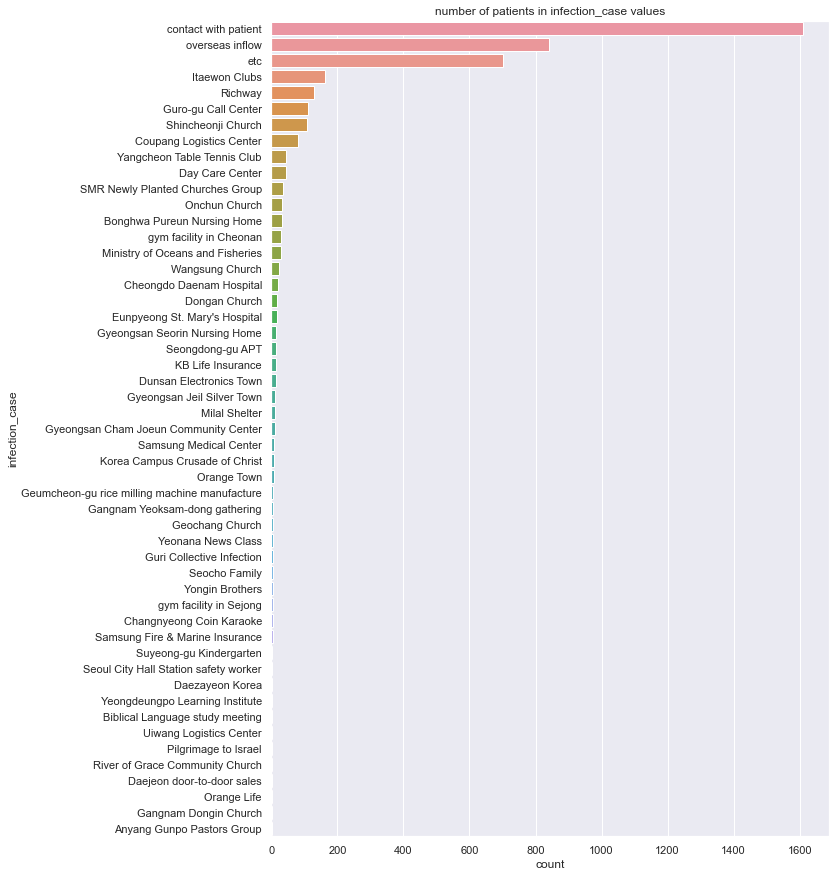

In [77]:
# 장소별 확진자 발생수 시각화

g = PI_df.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id':'count'}, inplace = True)
g = g.sort_values('count', ascending = False)

plt.figure(figsize = (10,15))
plt.title('number of patients in infection_case values')
sns.barplot(y = 'infection_case', x= 'count', data = g)
#display()

In [137]:

from datetime import date


PI_df["confirmed_date"][i].strftime('%Y%m%d')

'20200130'

TypeError: can only concatenate str (not "float") to str

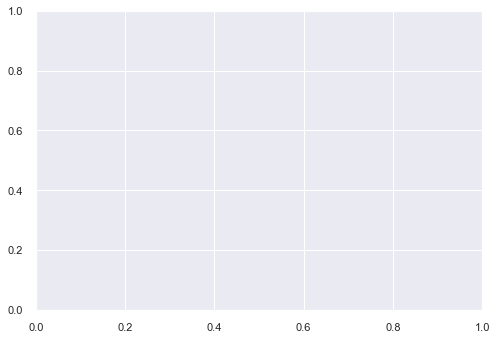

In [286]:
fig, ax = plt.subplots()

green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(PI_df['infection_case'], vert=False, flierprops=green_diamond)

sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips)

plt.title("tips box plot")
plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

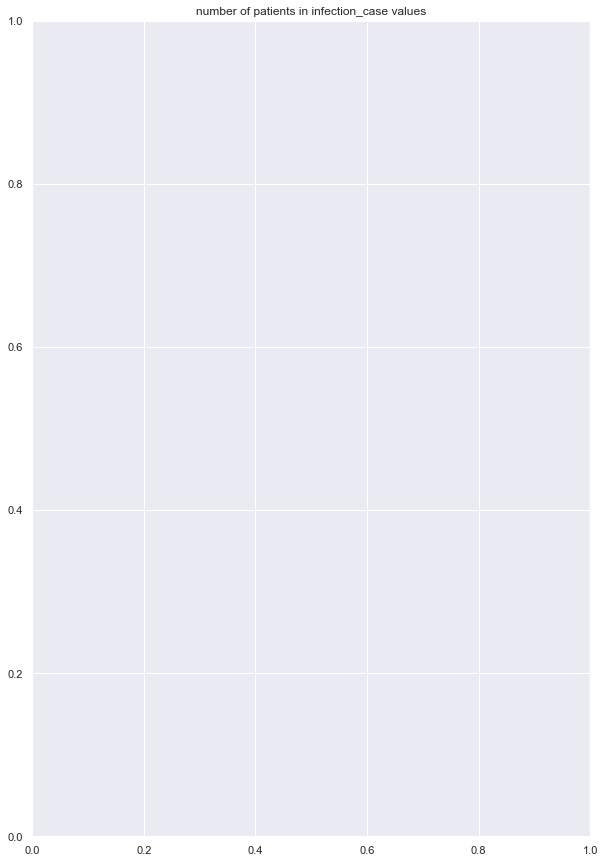

In [132]:
#x = PI_df['infection_case']
#y= PI_df['confirmed_date']



plt.figure(figsize = (10,15))
plt.title('number of patients in infection_case values')
sns.boxplot(x = "confirmed_date", y = 'infection_case', data = PI_df, vert=False)

plt.show()

#plt.figure(figsize = (10,20))

#(
#    ggplot(PI_df, aes("infection_case", "confirmed_date"))
#    +geom_boxplot(aes(colour="infection_case"))
#    +geom_boxplot()
#    +coord_flip()
#    +theme_light()+
#    ggtitle('Infection case')+theme(plot.title = element_text(hjust=0.5))
#)


In [16]:
# 계산 할 수 있도록 날짜의 데이터 타입을 변경해 준다.

PI_df['confirmed_date'] = pd.to_datetime(PI_df['confirmed_date'], format = '%Y-%m-%d')

In [17]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

train_date_min = PI_df['confirmed_date'].min()
train_date_max =PI_df['confirmed_date'].max()
print('Minimum date from training set: {}'.format(train_date_min))
print('Maximum date from training set: {}'.format(train_date_max))

Minimum date from training set: 2020-01-20 00:00:00
Maximum date from training set: 2020-06-30 00:00:00


In [18]:
# PatientInfo의 null 값은 총 3개가 존재 한다. 

PI_df['confirmed_date'].isnull().sum()

3

## 일자별 코로나 확진현황
Time.csv의 데이터를 사용해서 대한민국의 일별 코로나 확진현황을 살펴 보자.

In [150]:
def make_daily(df):
    daily = df.sort_values(['date'], ascending = False)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    only_case = []

    for i in range(len(daily)-1):
        only_case.append(daily['confirmed'][i]-daily['confirmed'][i+1])
    only_case.append(1)

    daily['daily'] = only_case

    daily = daily.sort_values(['date'],ascending=True)
    daily = daily.reset_index()
    daily = daily.drop(['index'],axis=1)
    
    return daily

In [151]:
# time data - date:날짜, confirmed:누적 확진자수 
time = pd.read_csv('./data/covid19/Time.csv', usecols= ['date', 'confirmed']) 
# time = make_daily(time)

In [299]:
# 그래프 

fig = go.Figure()

fig.add_trace(go.Line(x=time['date'], y = time['confirmed'], name = "일자별 누적 확진자 수(전국)", marker_color='#009770', yaxis="y"))
fig.add_trace(go.Bar(x=time['date'], y = time['daily'], name = "일자별 확진자 수(전국)", marker_color='#E91E63', yaxis="y2"))

fig.update_layout(shapes=[dict(fillcolor="rgba(211, 211, 211, 0.3)",line={"width": 0}, type="rect",x0="2020-02-25",x1="2020-03-09",xref="x",y0=0,y1=0.95,yref="paper")])

fig.update_layout(xaxis=dict(rangeslider=dict(autorange=True, range=["2020-01-20", "2020-06-30"],visible=True),type="date"),
                  yaxis=dict(anchor="x",autorange=True,domain=[0, 0.5],linecolor="#009770",mirror=True,range=[-60.0858369099, 28.4406294707],showline=True,side="right",
                             tickfont={"color": "#009770"},tickmode="auto",ticks="",titlefont={"color": "#009770"},type="linear",zeroline=False),
                  yaxis2=dict(anchor="x",autorange=True,domain=[0.5, 0.95],linecolor="#E91E63",mirror=True,range=[29.3787777032, 100.621222297],showline=True,side="right",
                             tickfont={"color": "#E91E63"},tickmode="auto",ticks="",titlefont={"color": "#E91E63"},type="linear",zeroline=False))

fig.update_layout(dragmode="zoom", hovermode="x", height=500, template="plotly_dark", title_text = "일자별 코로나 확진 현황", margin=dict(t=100, b=100))

fig.show()

## 1. Case.csv
한국의 COVID-19 감염 사례 데이터

In [205]:
# Case.csv 로드

display(C_df.head())

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374


In [206]:
# 필요한 column 추출한다.

C_df_modi = C_df[['city','infection_case', 'confirmed', 'latitude', 'longitude']]
display(C_df_modi.head())
display(C_df_modi.tail())

,city,infection_case,confirmed,latitude,longitude
0,Yongsan-gu,Itaewon Clubs,139,37.538621,126.992652
1,Gwanak-gu,Richway,119,37.48208,126.901384
2,Guro-gu,Guro-gu Call Center,95,37.508163,126.884387
3,Yangcheon-gu,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,Dobong-gu,Day Care Center,43,37.679422,127.044374


,city,infection_case,confirmed,latitude,longitude
169,-,etc,20,-,-
170,-,overseas inflow,14,-,-
171,-,contact with patient,0,-,-
172,-,etc,4,-,-
173,from other city,Itaewon Clubs,1,-,-


In [285]:
m = g.Map([36.4, 128], zoom_start=7)
fg = g.FeatureGroup(name='My Map')



for index, row in C_df_modi.iterrows():
    if row[3] and row[4] == '-':
        pass
        #print(row[4])
    else:
        
        #g.Marker(
        #    lication = [row[3],row[4]], 
        #    popup = row[1],
        #    icon = g.Icon(color='red')
        #).add_to(m)
        
        
        g.CircleMarker(
            location = [row[3],row[4]],
            fill_color='#ff3399',
            color = '#E91E63',
            radius = row['confirmed']*0.03,
            popup=int(row['confirmed'])
        ).add_to(m)
m

In [ ]:
fg.add_child(folium.Marker(location=[38.2, -99.1],popup="Hi I am a Marker",icon=folium.Icon(color="green")))

In [212]:
# Map위치를 잡는다.
# 모든 장소를 표시 하도록 코드를 수정해야 한다.

map = g.Map(location = [37.538621,126.992652], 
            zoom_start = 16, 
            tiles='OpenStreetMap')

# 마커 위치를 잡는다.

marker = g.Marker([37.538621,126.992652], 
                      popup = 'Itaewon Clubs',
                      icon = g.Icon(color='red'))

marker2 = g.CircleMarker([37.538621,126.992652],
                       radius=20,
                       color='red',
                       popup="Itaewon Clubs",
                       fill_color='red')

marker.add_to(map)
marker2.add_to(map)

map

In [126]:
# 

tmp = C_df['infection_case'].unique()
print(tmp)
len(tmp)

['Itaewon Clubs' 'Richway' 'Guro-gu Call Center'
 'Yangcheon Table Tennis Club' 'Day Care Center' 'Manmin Central Church'
 'SMR Newly Planted Churches Group' 'Dongan Church'
 'Coupang Logistics Center' 'Wangsung Church'
 "Eunpyeong St. Mary's Hospital" 'Seongdong-gu APT'
 'Jongno Community Center' 'Samsung Medical Center'
 'Jung-gu Fashion Company' 'Yeonana News Class'
 'Korea Campus Crusade of Christ' 'Gangnam Yeoksam-dong gathering'
 'Daejeon door-to-door sales'
 'Geumcheon-gu rice milling machine manufacture' 'Shincheonji Church'
 'Guri Collective Infection' 'KB Life Insurance'
 'Yeongdeungpo Learning Institute' 'Gangnam Dongin Church'
 'Biblical Language study meeting' 'Seocho Family'
 'Anyang Gunpo Pastors Group' 'Samsung Fire & Marine Insurance'
 'SJ Investment Call Center' 'Yongin Brothers'
 'Seoul City Hall Station safety worker' 'Uiwang Logistics Center'
 'Orange Life' 'Daezayeon Korea' 'overseas inflow' 'contact with patient'
 'etc' 'Onchun Church' 'Suyeong-gu Kindergarten'
 

81

## 3. Policy.csv
한국의 COVID-19에 대한 정부 정책 데이터

In [20]:
display(Pol_df.head())

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [36]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = Pol_df['start_date'].min(), Pol_df['start_date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-03
가장 최근의 날짜:  2020-06-10


## 4. Region.csv

In [22]:
R_df.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


## 5. SearchTrend.csv

In [23]:
ST_df.head()

,date,cold,flu,pneumonia,coronavirus
0,2016-01-01,0.11663,0.05590,0.15726,0.00736
1,2016-01-02,0.13372,0.17135,0.20826,0.00890
2,2016-01-03,0.14917,0.22317,0.19326,0.00845
3,2016-01-04,0.17463,0.18626,0.29008,0.01145
4,2016-01-05,0.17226,0.15072,0.24562,0.01381


In [35]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = ST_df['date'].min(), ST_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2016-01-01
가장 최근의 날짜:  2020-06-29


## 6. SeoulFloating
국내 최대 포털사이트 네이버에서 검색된 키워드의 트렌드 데이터

In [26]:
SF_df.head()

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450
3,2020-01-01,0,20,male,Seoul,Dongdaemun-gu,27050
4,2020-01-01,0,20,female,Seoul,Dongjag-gu,28880


In [34]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = SF_df['date'].min(), SF_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-01
가장 최근의 날짜:  2020-05-31


## 7. Time.csv
한국의 COVID-19 상황에 대한 시계열 데이터(테스트, 음성, 양성, 해제, 누적 사망자)

In [30]:
T_df.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


In [33]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = T_df['date'].min(), T_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30


## 8. TimeAge.csv
한국의 연령별 코로나19 현황 시계열 데이터

In [39]:
TA_df.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [41]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TA_df['date'].min(), TA_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-03-02
가장 최근의 날짜:  2020-06-30


## 9. TimeGender.csv
한국의 성별별 코로나19 현황 시계열 데이터

In [43]:
TG_df.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


In [45]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TG_df['date'].min(), TG_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-03-02
가장 최근의 날짜:  2020-06-30


## 10. TimeProvince.csv
한국의 지역별 코로나19 현황 시계열 데이터

In [47]:
TP_df.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0


In [49]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = TP_df['date'].min(), TP_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30


## 11. Weather.csv
한국 지역의 날씨 데이터

In [51]:
W_df.head()

,code,province,date,avg_temp,min_temp,max_temp,precipitation,max_wind_speed,most_wind_direction,avg_relative_humidity
0,10000,Seoul,2016-01-01,1.2,-3.3,4.0,0.0,3.5,90.0,73.0
1,11000,Busan,2016-01-01,5.3,1.1,10.9,0.0,7.4,340.0,52.1
2,12000,Daegu,2016-01-01,1.7,-4.0,8.0,0.0,3.7,270.0,70.5
3,13000,Gwangju,2016-01-01,3.2,-1.5,8.1,0.0,2.7,230.0,73.1
4,14000,Incheon,2016-01-01,3.1,-0.4,5.7,0.0,5.3,180.0,83.9


In [52]:
# 가장 최근과 예전의 시간 데이터를 확인해 보자

oldest, latest = T_df['date'].min(), T_df['date'].max()
print('가장 오래된 날짜: ',oldest) 
print('가장 최근의 날짜: ',latest)

가장 오래된 날짜:  2020-01-20
가장 최근의 날짜:  2020-06-30


## Explorotary Data Analysis